## Animal keypoint regression
### Get the data

In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget --load-cookies /tmp/cookies.txt \
    "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1v5w2lMfjE3FZRPXsJKUli7NaKhVFvBGj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1v5w2lMfjE3FZRPXsJKUli7NaKhVFvBGj" \
    -O stanfordextra_v12.zip && rm -rf /tmp/cookies.txt

!mkdir -p data
!tar xf images.tar -C data/
!unzip -oqq stanfordextra_v12.zip -d data/

!rm images.tar stanfordextra_v12.zip

## Dataset Structure

A single entry of StanfordExtra_v12.json looks like the following:

```
'n02085782-Japanese_spaniel/n02085782_2886.jpg':
{'img_bbox': [205, 20, 116, 201],
 'img_height': 272,
 'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg',
 'img_width': 350,
 'is_multiple_dogs': False,
 'joints': [[108.66666666666667, 252.0, 1],
            [147.66666666666666, 229.0, 1],
            [163.5, 208.5, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [54.0, 244.0, 1],
            [77.33333333333333, 225.33333333333334, 1],
            [79.0, 196.5, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [150.66666666666666, 86.66666666666667, 1],
            [88.66666666666667, 73.0, 1],
            [116.0, 106.33333333333333, 1],
            [109.0, 123.33333333333333, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
 'seg': ...}
```

## Install libs

In [ ]:
!pip install -r requirements.txt

### Import Libraries

In [1]:
import os
import torch
from tqdm.notebook import tqdm
from collections import defaultdict
from torchvision import transforms

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from utils.transforms import (
    ScaleMinSideToSize,
    CropCenter,
    TransformByKeys,
    Cutout,
    UnNormalize,
    RandomLandmarksRotation,
)

from utils.loss import (
    WingLoss,
    FocalLoss,
)
from utils.collector import Collector
from utils.model import (
    getModelTorchvision,
    getModelTIMM,
    getMyCustomNet,
)

from utils.dataset import LandmarksDataset

### Random seed

In [2]:
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Define training function

In [3]:
def trainer(
    model,
    optimizer,
    scheduler,
    dataloaders_dict,
    num_epochs,
    device,
    loss_function,
    visualiser,
):
    
    loss_per_epoch = defaultdict(list)
    min_val_loss = 1e10
    
    for epoch in range(num_epochs):
        
        loss_per_batch = defaultdict(list)
        
        for phase in dataloaders_dict:
            
            phase_train = phase == 'train'
            
            model.train() if phase_train else model.eval()
            
            for gt_batch in tqdm(dataloaders_dict[phase], desc=phase, total=len(dataloaders_dict[phase])):
                
                gt_batch = {
                    key: gt_batch[key].to(device)
                    for key in gt_batch
                }
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase_train):
                    
                    preds_batch = model(gt_batch['image'])
                    loss_batch = loss_function(gt_batch, preds_batch)
                    
                    if phase_train:
                        
                        loss_batch.backward()
                        optimizer.step()
                        scheduler.step()
                    
                    loss_per_batch[phase].append(loss_batch.item())
                    
            loss_per_epoch[phase].append(
                sum(loss_per_batch[phase]) / len(dataloaders_dict[phase].dataset)
            )
            
        if loss_per_epoch['val'][-1] < min_val_loss:
            min_val_loss = loss_per_epoch['val'][-1]
            torch.save(model.state_dict(), 'model.pth')
            
        if visualiser is not None:
            visualiser.step(loss_per_epoch)

### Global constants

In [4]:
bs = 64
num_points = 24
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone_type = 'resnet34d'
crop_size = 224
train_size = 0.9

root_images = 'data/Images/'
root_labels = 'data/StanfordExtra_V12/StanfordExtra_v12.json'
epochs = 40

print('Device is', device)

Device is cuda


### Transformations

In [5]:
transformations = {
    'train': transforms.Compose([
        ScaleMinSideToSize((crop_size, crop_size)),
        #CropCenter(crop_size),
        TransformByKeys(transforms.ToPILImage(), ('image',)),
        RandomLandmarksRotation(10),
        TransformByKeys(transforms.ToTensor(), ('image',)),
        transforms.RandomApply([TransformByKeys(transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), ('image',)), ], p=0.3),
        TransformByKeys(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, True), ('image',)),
        transforms.RandomApply([
            Cutout(2, 30),
        ], p=0.3)
    ]),
    
    'val': transforms.Compose([
        ScaleMinSideToSize((crop_size, crop_size)),
        #CropCenter(crop_size),
        TransformByKeys(transforms.ToPILImage(), ('image',)),
        TransformByKeys(transforms.Resize((crop_size, crop_size)), ('image',)),
        TransformByKeys(transforms.ToTensor(), ('image',)),
        TransformByKeys(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, True), ('image',)),
    ]),
}

### Define dataloaders

In [6]:
datasets = {
    phase: LandmarksDataset(
        root_images=root_images,
        root_labels=root_labels,
        transforms=transformations[phase],
        split=phase,
        train_size=train_size,
        k=1.5,
    )
    for phase in transformations
}

dataloaders = {
    phase: torch.utils.data.DataLoader(
        dataset=datasets[phase],
        batch_size=bs,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    for phase in transformations
}

### Define utils

In [7]:
model = getMyCustomNet(
    backbone_type=backbone_type,
    n_keypoints=num_points*2,
    n_classes=len(datasets['train'].class_names),
    device=device,
)
optim = torch.optim.AdamW(
    params=model.parameters(),
    lr=5e-3,
    weight_decay=1e-3,
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optim,
    max_lr=5e-3,
    steps_per_epoch=len(datasets['train']),
    epochs=epochs,
)
visualiser = Collector(
    root_graphics=f'metrics/{backbone_type}_',
    root_desc=f'metrics/{backbone_type}_',
    phases=['train', 'val'],
)

## Define Loss function for 2 heads

In [8]:
def custom_loss(
    gt: dict,
    preds: dict,
):
    clf = torch.nn.functional.cross_entropy(
        input=preds['classes'],
        target=gt['classes'],
    )
    
    b, lm = preds['landmarks'].size()
    
    reg = torch.nn.functional.l1_loss(
        input=(preds['landmarks'].reshape(b, -1, 2) * gt['visibles'].reshape(b, -1, 1)).reshape(b, -1),
        target=gt['landmarks'],
    )
    
    loss = 2.0*reg + 1.0*clf
    
    return loss

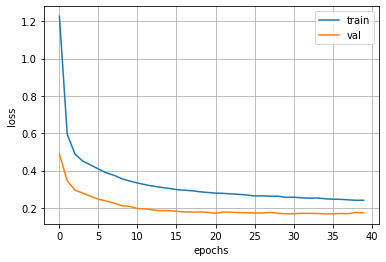

In [9]:
trainer(model, optim, scheduler, dataloaders, epochs, device, custom_loss, visualiser)

## Define function for prediction of one photo by path

In [32]:
def predict(
    model,
    image_path: str,
    bbox: list,
    transforms,
    id_to_class: dict,
    num_points: int=24,
) -> tuple:
    
    '''predict dog class and length of tail
        
    input: model (pytorch)
    input: image_path (str)
    input: bbox (list): left top corner, right down corner
    
    output: (tuple): dog class (str) and tail length (float, 0<=...<=1)
    '''
    
    model.eval()
    
    image = cv2.imread(image_path)
    #im_h, im_w, _ = image.shape
    
    #xl, yl, xr, yr = bbox
    #bbox_h, bbox_w = yr - yl, xr - xl
    
    #xc, yc = (xr + xl) / 2, (yr + yl) / 2
    #k=1.2
    
    #ystart = np.clip(yc - k*bbox_h/2, 0, im_h).astype(int)
    #ystop = np.clip(yc + k*bbox_h/2, 0, im_h).astype(int)
    #xstart = np.clip(xc - k*bbox_w/2, 0, im_w).astype(int)
    #xstop = np.clip(xc + k*bbox_w/2, 0, im_w).astype(int)
    
    #sample = {
    #    'image': cv2.cvtColor(image[ystart:ystop, xstart:xstop], cv2.COLOR_BGR2RGB)
    #}
    
    sample = {
        'image': cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    }
    sample = transforms(sample)
    
    with torch.no_grad():
        preds = model(sample['image'].cuda().unsqueeze(0))
    
    class_id = preds['classes'].squeeze(0).cpu().numpy().argmax()
    pred_landmarks = preds['landmarks'].squeeze(0).cpu().numpy().reshape((num_points, 2))
    
    tail_length = np.linalg.norm(pred_landmarks[12] - pred_landmarks[13])
    body_length = np.linalg.norm(pred_landmarks[16] - pred_landmarks[13])
    
    return (id_to_class[class_id], np.clip(tail_length/body_length, 0, 1))

In [24]:
predict(
    model=model,
    image_path='data/Images/n02085782-Japanese_spaniel/n02085782_2886.jpg',
    bbox=[205, 20, 205+116, 20+201],
    transforms=transformations['val'],
    id_to_class={i: class_ for class_, i in datasets['train'].class_names.items()},
)

('n02085782-Japanese_spaniel', 0.12189903855323792)

## Evaluate the model on real-life photos

In [92]:
id_to_class={i: class_ for class_, i in datasets['train'].class_names.items()}
tails_root = 'data/tails'
gts, preds = [], []
max_ac = 0
max_tr = 0
max_rec = 0
max_prec = 0

for tr in tqdm(np.linspace(0.01, 0.9, 20)):
    gts, preds = [], []
    for class_dir in os.listdir(tails_root):
        class_id = int(class_dir)
        full_path_dir = os.path.join(tails_root, class_dir)
        for image in os.listdir(full_path_dir):
            image_path = os.path.join(full_path_dir, image)
            _, length = predict(model, image_path, [], transformations['val'], id_to_class)
            pred = 1 if length > tr else 0
            gts.append(class_id)
            preds.append(pred)
        
    acc = sklearn.metrics.balanced_accuracy_score(gts, preds)
    if acc > max_ac:
        max_ac = acc
        max_tr = tr
        max_prec = sklearn.metrics.precision_score(gts, preds)
        max_rec = sklearn.metrics.recall_score(gts, preds)
        print('balanced:', max_ac, 'tresh:', max_tr, 'precision:', max_prec, 'recall:', max_rec)

  0%|          | 0/20 [00:00<?, ?it/s]

balanced: 0.5 tresh: 0.01 precision: 0.3891891891891892 recall: 1.0
balanced: 0.5057153392330384 tresh: 0.056842105263157895 precision: 0.39204545454545453 recall: 0.9583333333333334
balanced: 0.5070058997050148 tresh: 0.10368421052631578 precision: 0.39285714285714285 recall: 0.9166666666666666
balanced: 0.5095870206489675 tresh: 0.15052631578947367 precision: 0.39473684210526316 recall: 0.8333333333333334
balanced: 0.528023598820059 tresh: 0.2442105263157895 precision: 0.41025641025641024 recall: 0.6666666666666666
balanced: 0.5388397246804326 tresh: 0.29105263157894734 precision: 0.425531914893617 recall: 0.5555555555555556


## Visualisation of train batch

In [12]:
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

In [26]:
def visualize_prediction(
    model,
    dataset,
    num_points,
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
    indexes=None
):
    
    plt.figure(figsize=(26, 10))
    
    unnorm = UnNormalize(mean, std)
    resize = transforms.Resize((crop_size, crop_size))
    model.eval()
    id_to_class = {i: class_ for class_, i in dataset.class_names.items()}

    for i in range(10):
        if indexes is not None:
            index = indexes[i]
        else:
            index = random.randint(0, len(dataset))
            
        sample = dataset[index]
        image = sample['image']
        
        with torch.no_grad():
            preds = model(resize(image).cuda().unsqueeze(0))
            class_id = preds['classes'].squeeze(0).cpu().numpy().argmax()
            pred_landmarks = preds['landmarks'].squeeze(0).cpu().numpy().reshape((num_points, 2))
        
        image = (unnorm(image).permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        image = image.copy()
        
        if 'landmarks' in sample:
            landmarks = sample['landmarks'].numpy().reshape((num_points, 2))
            
            #for point in landmarks:
                #x, y = point.astype(np.int32)
                #cv2.circle(image, (x, y), 10, (128, 0, 128), 3, -1)
        
        for point in pred_landmarks:
            x, y = point.astype(np.int)
            cv2.circle(image, (x, y), 10, (170, 150, 50), 5, -1)
            
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(id_to_class[class_id], fontsize=15)
        plt.imshow(image);

/tmp/ipykernel_1012950/2570406115.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x, y = point.astype(np.int)


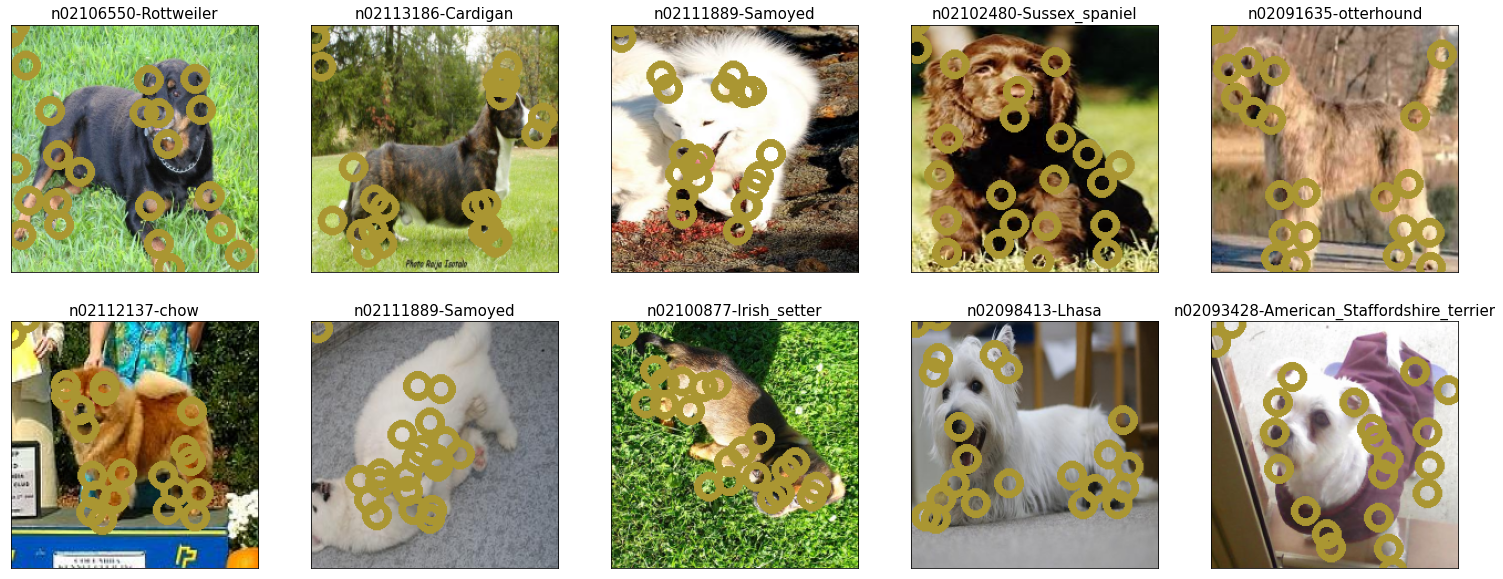

In [18]:
visualize_prediction(model, datasets['val'], num_points)